# 0. Installation of necessary packages

In [1]:
# !pip install hestia-good PyTDC rdkit transformers

# 1. Data preparation

In this tutorial, we will use the Ames' mutageneicity dataset from the TDC library

In [2]:
import pandas as pd
from tdc.single_pred import Tox

data = Tox('dili')
df = pd.read_csv('data/dili.tab', sep='\t')
df.head()

Found local copy...
Loading...
Done!


,Drug_ID,Drug,Y
0,187.0,CC(=O)OCC[N+](C)(C)C,0.0
1,247.0,C[N+](C)(C)CC(=O)[O-],0.0
2,298.0,O=C(NC(CO)C(O)c1ccc([N+](=O)[O-])cc1)C(Cl)Cl,0.0
3,338.0,O=C(O)c1ccccc1O,0.0
4,444.0,CC(NC(C)(C)C)C(=O)c1cccc(Cl)c1,0.0


# 2. Initialisating HestiaGenerator

In this tutorial, we create two sets of partitions:
1. The conventional `ECFP-4` fingerprint with 2,048 bits and Tanimoto index (faster, less resolution).
2. A new fingerprint type called `MAPc`, also with radius 2 and 2,048 bits and Jaccard index (slower, more resolution).

In [3]:
from hestia import HestiaGenerator, SimArguments

sim_args_1 = SimArguments(
    # Change in case of biosequences, protein structures, or embeddings
    data_type='molecule',
    # Corresponds to the field with the molecule SMILES
    field_name='Drug',
    # Minimum threshold to attempt to find a viable partition, if memory problems it can be raised
    min_threshold=0.,
    verbose=3,
    sim_function='tanimoto',
    bits=2048,
    # ECFP-4 has diameter 4, therefore radius 2
    radius=2,
    fingerprint='ecfp'
)
# Initialise generator
hg_1 = HestiaGenerator(df, verbose=True)

# Generate partitions with similarity function described above
hg_1.calculate_partitions(
    sim_args=sim_args_1,
    # Label name for classification tasks, keeps label balance if possible
    label_name='Y',
    threshold_step=0.1,
    test_size=0.2,
    valid_size=0.1
)


Initialising Hestia Dataset Generator
Number of items in data: 475
Calculating similarity...
Calculating molecular similarities using ecfp with 2,048 bits, radius 2 and tanimoto index...


Similarity calculation: 100%|██████████| 475/475 [00:00<00:00, 4.56kit/s]


Similarity successfully calculated!
Calculating partitions...


100%|██████████| 10/10 [00:00<00:00, 146.95it/s]

Partitions successfully calculated!


In [4]:
sim_args_2 = SimArguments(
    data_type='molecule',
    field_name='Drug',
    min_threshold=0.,
    verbose=3,
    # Changed to jaccard
    sim_function='jaccard',
    bits=2048,
    radius=2,
    # Changed to MAPc
    fingerprint='mapc'
)
# Initialise generator
hg_2 = HestiaGenerator(df, verbose=True)

# Generate partitions with similarity function described above
hg_2.calculate_partitions(
    sim_args=sim_args_2,
    # Label name for classification tasks, keeps label balance if possible
    label_name='Y',
    threshold_step=0.1,
    test_size=0.2,
    valid_size=0.1,
)

Initialising Hestia Dataset Generator
Number of items in data: 475
Calculating similarity...
Calculating molecular similarities using mapc with 2,048 bits, radius 2 and jaccard index...


Similarity calculation: 100%|██████████| 475/475 [00:00<00:00, 1.66kit/s]


Similarity successfully calculated!
Calculating partitions...


100%|██████████| 10/10 [00:00<00:00, 153.03it/s]

Partitions successfully calculated!


# 3. Evaluation of similarity functions

In this tutorial, we will use a linear SVM with ECFP-4 with 2,048 bits as its features to evaluate the similarity functions.

In [5]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import cpu_count
from typing import List
from sklearn.metrics import matthews_corrcoef
from sklearn.svm import LinearSVC

# Define fingerprints for featurization
fpgen = rdFingerprintGenerator.GetMorganGenerator(
    radius=2, fpSize=2048
)
def _get_fp(smile: str):
    mol = Chem.MolFromSmiles(smile)
    fp = fpgen.GetFingerprintAsNumPy(mol).astype(np.int8)
    return fp

# Calculate FPs in parallel
def _parallel_fps(mols: List[str], mssg: str) -> list:
    fps = []
    jobs = []
    with ThreadPoolExecutor(max_workers=cpu_count()) as executor:
        for mol in mols:
            job = executor.submit(_get_fp, mol)
            jobs.append(job)

        pbar = tqdm(jobs, desc=mssg, unit_scale=True,
                    mininterval=0.5, maxinterval=2)

        for job in pbar:
            if job.exception() is not None:
                raise RuntimeError(job.exception())
            result = job.result()
            fps.append(result)
    return fps

#  We define the features and labels for the model
x = np.stack(_parallel_fps(df.Drug.tolist(), "Features"))
y = df.Y.to_numpy()
result = {
    'sim_function': [],
    'threshold': [],
    'performance': []
}

# We iterate over both similarity functions
for sim_idx, hg in enumerate([hg_1, hg_2]):

    # We filter non-viable partitions (those with test set with less than 18.5% of the total data)
    for th, part in hg.get_partitions(filter=0.185):
        print(f"Computing partitions: {th} for sim function: {sim_idx}")
        train_x, valid_x, test_x = x[part['train']], x[part['valid']], x[part['test']]
        train_y, valid_y, test_y = y[part['train']], y[part['valid']], y[part['test']]
        result['sim_function'].append(sim_idx)
        result['threshold'].append(th)
        model = LinearSVC()
        model.fit(train_x, train_y)
        test_y_pred = model.predict(test_x)
        result['performance'].append(matthews_corrcoef(test_y_pred, test_y))

result_df = pd.DataFrame(result)


Features: 100%|██████████| 475/475 [00:00<00:00, 1.09Mit/s]


Computing partitions: 0.3 for sim function: 0
Computing partitions: 0.4 for sim function: 0
Computing partitions: 0.5 for sim function: 0
Computing partitions: 0.6 for sim function: 0
Computing partitions: 0.7 for sim function: 0
Computing partitions: 0.8 for sim function: 0
Computing partitions: 0.9 for sim function: 0
Computing partitions: random for sim function: 0
Computing partitions: 0.1 for sim function: 1
Computing partitions: 0.2 for sim function: 1
Computing partitions: 0.3 for sim function: 1
Computing partitions: 0.4 for sim function: 1
Computing partitions: 0.5 for sim function: 1
Computing partitions: 0.6 for sim function: 1
Computing partitions: 0.7 for sim function: 1
Computing partitions: 0.8 for sim function: 1
Computing partitions: 0.9 for sim function: 1
Computing partitions: random for sim function: 1


## 3.1 Visual inspection

<Axes: xlabel='threshold', ylabel='performance'>

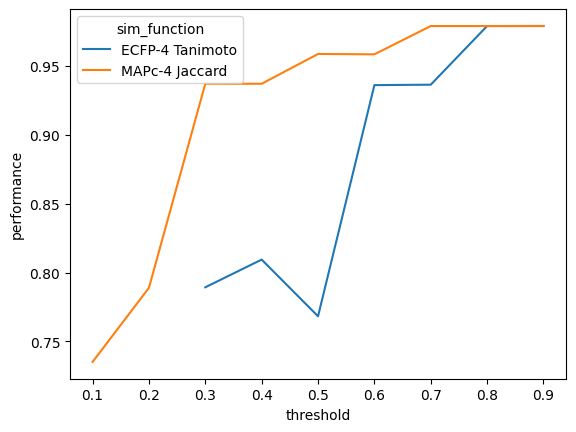

In [6]:
import seaborn as sns

sim_functions = ['ECFP-4 Tanimoto', "MAPc-4 Jaccard"]
result_df['sim_function'] = result_df.sim_function.map(lambda x: sim_functions[x])
result_df = result_df[result_df.threshold != 'random']
sns.lineplot(result_df, x='threshold', y='performance', hue='sim_function', err_style='bars')

Both curves are somewhat noisy, this can be mitigated by performing cross-validation to reduce the effect of model stochasticity in the results.

However, MAPc shows a larger threshold range and a greater distance between highest and lowest point showing increased resolution. Next step will provide quantitative measures for those qualitative observations.

## 3.2 Quantitative analysis

We provide two quantitative measures to compare the similarity functions:

1. `dynamic range`: distance between maximum and minimum viable thresholds
2. `monotonicity`: non-linear correlation (Spearman's $\rho$) between threshold and model performance. Closer to 1 means that the model performance **is** a function of the threshold. And therefore the similarity function is reliable, closer to 0 means the opposite.

A similarity function should have a decent dynamic range and as great a monotonicity as possible. Monotonicities below 0.4 are unreliable.

In [7]:
c_1 = result_df[result_df['sim_function'] == sim_functions[0]]
monotonicity, dynamic_range = hg.evaluate_curve(c_1.threshold, c_1.performance)
print(f"{sim_functions[0]} - monotonicity: {monotonicity} - dynamic range: {dynamic_range}")
c_2 = result_df[result_df['sim_function'] == sim_functions[1]]
monotonicity, dynamic_range = hg.evaluate_curve(c_2.threshold, c_2.performance)
print(f"{sim_functions[1]} - monotonicity: {monotonicity} - dynamic range: {dynamic_range}")


ECFP-4 Tanimoto - monotonicity: 0.8829187134416479 - dynamic range: 0.6000000000000001
MAPc-4 Jaccard - monotonicity: 0.9623515200690814 - dynamic range: 0.8


The MAPc-4 Jaccard similarity function is superior both in terms of its monotonicity and dynamic range

# 4. Evaluation of other models

Here now we will use the `hg_2` with the best similarity function we've found so far, for evaluating the linear SVM against a random forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
result = {
    'model': [],
    'threshold': [],
    'performance': []
}
for model in ['svm', 'rf']:
    for th, part in hg_2.get_partitions(filter=0.185):
        print(f"Computing partitions: {th} for model: {model}")
        train_x, valid_x, test_x = x[part['train']], x[part['valid']], x[part['test']]
        train_y, valid_y, test_y = y[part['train']], y[part['valid']], y[part['test']]
        result['model'].append(model)
        result['threshold'].append(th)
        if model == 'svm':
            c = LinearSVC()
        else:
            c = RandomForestClassifier(n_estimators=100)
        c.fit(train_x, train_y)
        test_y_pred = c.predict(test_x)
        result['performance'].append(matthews_corrcoef(test_y_pred, test_y))


result_df = pd.DataFrame(result)

Computing partitions: 0.1 for model: svm
Computing partitions: 0.2 for model: svm
Computing partitions: 0.3 for model: svm
Computing partitions: 0.4 for model: svm
Computing partitions: 0.5 for model: svm
Computing partitions: 0.6 for model: svm
Computing partitions: 0.7 for model: svm
Computing partitions: 0.8 for model: svm
Computing partitions: 0.9 for model: svm
Computing partitions: random for model: svm
Computing partitions: 0.1 for model: rf
Computing partitions: 0.2 for model: rf
Computing partitions: 0.3 for model: rf
Computing partitions: 0.4 for model: rf
Computing partitions: 0.5 for model: rf
Computing partitions: 0.6 for model: rf
Computing partitions: 0.7 for model: rf
Computing partitions: 0.8 for model: rf
Computing partitions: 0.9 for model: rf
Computing partitions: random for model: rf


## 4.1 GOOD curve

<Axes: xlabel='threshold', ylabel='performance'>

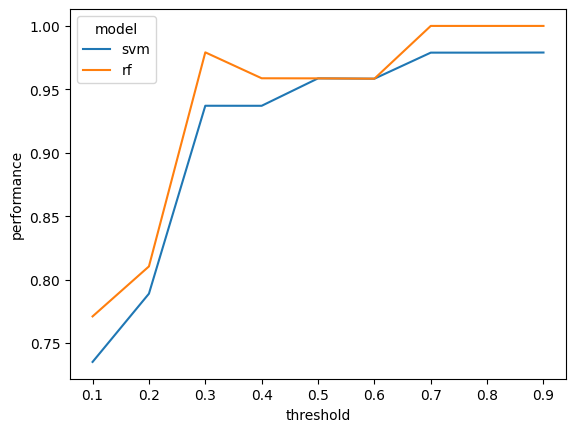

In [9]:
# Plot GOOD curve
result_df = result_df[result_df['threshold'] != 'random']
sns.lineplot(result_df, x='threshold', y='performance', hue='model')

Though, they both have similar performance and in some thresholds even identical, the `RandomForest` achieves better performance overall. Choosing one threshold alone, might have led to incorrect conclusions about their differences.

## 4.2 AU-GOOD metric

Let us consider the case where we want to apply this dataset to the drug repurposing hub. We can estimate the model performance for that target distribution through the calculation of the AU-GOOD metric.

In [10]:
target_df = pd.read_csv('data/drh.tsv', sep='\t')
smiles = target_df['SMILES']
new_smiles = []
for smile in smiles:
    if isinstance(smile, float):
        continue
    if ',' in smile:
        in_smiles = smile.split(', ')
        new_smiles.extend(in_smiles)
    else:
        new_smiles.append(smile)
new_smiles = [s if '|' not in s else s.split('|')[0] for s in new_smiles]
tgt_df = pd.DataFrame({'SMILES': new_smiles})
tgt_df.head()

,SMILES
0,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31
1,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31
2,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31
3,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31
4,COc1ccc(cc1OC1CCCC1)[C@@H]1CNC(=O)C1


In [11]:
values = []
for model in ['svm', 'rf']:
    mini_df = result_df[result_df['model'] == model]
    good_curve, augood = hg_2.calculate_augood(
        results={th: val for th, val in zip(mini_df.threshold, mini_df.performance)},
        target_df=tgt_df,
        target_field_name='SMILES',
        return_weights=False
    )
    values.append(augood)
for idx, model in enumerate(['svm', 'rf']):
    print(f"AU-GOOD for model: {model} against Drug Repurposing Hub is {values[idx]:.3g}")

Calculating similarity...
Calculating molecular similarities using mapc with 2,048 bits, radius 2 and jaccard index...


Query FPs: 100%|██████████| 475/475 [00:02<00:00, 206it/s]
Target FPs: 100%|██████████| 20.3k/20.3k [00:47<00:00, 425it/s]  
Similarity calculation: 100%|██████████| 475/475 [00:08<00:00, 56.6it/s] 


Similarity successfully calculated!
Calculating similarity...
Calculating molecular similarities using mapc with 2,048 bits, radius 2 and jaccard index...


Query FPs: 100%|██████████| 475/475 [00:02<00:00, 185it/s]
Target FPs: 100%|██████████| 20.3k/20.3k [00:12<00:00, 1.56kit/s]
Similarity calculation: 100%|██████████| 475/475 [00:07<00:00, 65.4it/s] 


Similarity successfully calculated!
AU-GOOD for model: svm against Drug Repurposing Hub is 0.942
AU-GOOD for model: rf against Drug Repurposing Hub is 0.962


# 5. Save/Load Hestia Generator

In [ ]:
hg_2.save_precalculated('dili_partitions.gz')

hg_3 = HestiaGenerator(df)
hg_3.from_precalculated('dili_partitions.gz')

Initialising Hestia Dataset Generator
Number of items in data: 475
{'partition_algorithm': {'algorithm': 'ccpart', 'min_threshold': 0, 'threshold_step': 10, 'test_size': 0.2, 'valid_size': 0.1, 'random_state': 42, 'n_partitions': None}, 'similarity_metric': {'data_type': 'molecule', 'field_name': 'Drug', 'min_threshold': 0.0, 'threads': 10, 'verbose': 3, 'save_alignment': False, 'filename': 'alignment', 'target_df':                                                   SMILES  \
0                 CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31   
1                 CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31   
2                 CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31   
3                 CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31   
4                   COc1ccc(cc1OC1CCCC1)[C@@H]1CNC(=O)C1   
...                                                  ...   
20278                              Nc1c2ccccc2nc2ccccc12   
20279  CC[C@@]1(O)C(=O)OCc2c1cc1-c3nc4cccc(N)c4cc3Cn1...   
20280  CC[C@@]1(O)C(=O)OCc2c1cc1-c3nc4cc